# CS375 - Tutorial 2

### Welcome to tutorial 2! This tutorial will introduce you to unsupervised learning methods, specifically how to train a sparse autoencoder and variational autoencoder on MNIST, and how to evaluate the trained model on neural data. As before everything will be implemented using TFUtils. We will start with a sparse autoencoder and then move on to variational autoencoders.

## 1.) Training and evaluating a sparse autoencoder on MNIST
### Sparse autoencoders try to find a compact, low dimensional representation of the input data under some sparsity constraint such that the input data is recoverable in the best way possible from the found representation. Autoencoders consist of an encoder that encodes the input into a low dimensional representation and a decoder that decodes the low dimensional representation into the original input. Thus, the supervision signal during training of an autoencoder is the input itself and oftentimes a l2 loss is used to regress the input. Due to the low dimensionality constraint, the structure of an autoencoder usually resembles a "bottleneck", where the encoder first reduces the number of activations and the decoder expands the number of activations to the input's original size. In the special case of sparse autoencoders, one also imposes a sparsity constraint most often in the form of a l1-norm  over the network's activations aditionally to a l2 regularization of the weights, which enforces the network outputs and weights to be small values close to zero and thus them to be sparse.

### Now let's define a simple sparse autoencoder consisting of one fully connected layer in the encoder and one fully connected layer in the decoder. We will first define the model function:

##### Note commands will yield different results on the cluster and might throw errors if you have altered the parameters. Adjust your path, databases etc. according to your experiment settings. This holds true for the whole tutorial.

In [107]:
%matplotlib inline
from __future__ import division
from tfutils import base, data, optimizer, utils

import numpy as np
import tensorflow as tf
import os
import pymongo as pm
import matplotlib.pyplot as plt
import scipy.signal as signal

# connect to database
dbname = 'mnist'
collname = 'autoencoder'
port = 24444
conn = pm.MongoClient(port = port)
coll = conn[dbname][collname + '.files']

def sparse_autoencoder(inputs, train=True, beta = 5e-4, n_hidden = 100, **kwargs): 
    '''
    Implements a simple autoencoder consisting of two fully connected layers
    '''
    # flatten the input images
    inp = tf.reshape(inputs['images'], [inputs['images'].get_shape().as_list()[0], -1])
    
    outputs = {}
    # create encoder variables and encode the input
    # note how we use a l1-regulalizer on the weights 
    with tf.variable_scope('encoder'):
        W1 = tf.get_variable('W1', [784, n_hidden], tf.float32, tf.contrib.layers.xavier_initializer(),
                            regularizer = tf.contrib.layers.l2_regularizer(scale=beta))
        b1 = tf.get_variable('b1', [n_hidden], tf.float32, tf.constant_initializer(0))
        
        representation = tf.tanh(tf.matmul(inp, W1) + b1, name='encoding')
        outputs['representation'] = representation
        
    # create decoder variables and decode the low dimensional representation
    with tf.variable_scope('decoder'):
        W2 = tf.get_variable('W2', [n_hidden, 784], tf.float32, tf.contrib.layers.xavier_initializer(),
                            regularizer = tf.contrib.layers.l2_regularizer(scale=beta))
        b2 = tf.get_variable('b2', [784], tf.float32, tf.constant_initializer(0))
        
        outputs['pred'] = tf.tanh(tf.matmul(representation, W2) + b2, name='decoding')

    return outputs, {}

### Next, we will define our loss which we choose to be a l2-loss with the inputs being the optimization target:

In [108]:
def sparse_autoencoder_loss(inputs, outputs, alpha = 0.1, **kwargs):
    '''
    Defines the loss = l2(inputs - outputs) + l2(weights)
    '''
    # flatten the input images
    inputs = tf.reshape(inputs, [inputs.get_shape().as_list()[0], -1])
    # the total optimization target is the weighted sum of the l2 loss on the input 
    # and the l1 regularization on the weights
    return tf.nn.l2_loss(inputs - outputs['pred']) / tf.cast(tf.shape(inputs)[1], tf.float32) + \
            alpha * tf.norm(outputs['representation'], ord=1) / tf.cast(tf.shape(outputs['representation'])[1], tf.float32) + \
            tf.reduce_sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))

def sparse_autoencoder_validation(inputs, outputs, **kwargs):
    '''
    Wrapper for using the loss function as a validation target
    '''
    return {'total_loss': sparse_autoencoder_loss(inputs['images'], outputs),
            'pred': outputs['pred'],
            'gt': inputs['images']}

### Now let's define our sparse autoencoder experiment on MNIST in TFUtils. We will use the Adam optimizer and an exponentially decaying learning rate:

In [ ]:
os.environ['CUDA_VISIBLE_DEVICES'] = "2"

def online_agg_mean(agg_res, res, step):
    """
    Appends the mean value for each key
    """
    if agg_res is None:
        agg_res = {k: [] for k in res}
    for k, v in res.items():
        if k in ['pred', 'gt']:
            value = v
        else:
            value = np.mean(v)
        agg_res[k].append(value)
    return agg_res

def agg_mean(results):
    for k in results:
        if k in ['pred', 'gt']:
            results[k] = results[k][0]
        elif k is 'total_loss':
            results[k] = np.mean(results[k])
        else:
            raise KeyError('Unknown target')
    return results

# number of hidden neurons
n_hidden = 100
# scaling of l2 regularization on weights
beta = 1e-2 # 1e-4 = no regularization | 1e-2 = with regularization
# scaling of l1 regularization on activations
alpha = 0.5 # 0 = no regularization -> with overfitting | 0.5 = with regularization -> no overfitting

params = {}

params['load_params'] = {
    'do_restore': False,
}

params['save_params'] = {
    'host': 'localhost',
    'port': 24444,
    'dbname': 'mnist',
    'collname': 'autoencoder',
    'exp_id': 'exp1',
    'save_metrics_freq': 200,
    'save_valid_freq': 200,
    'save_filters_freq': 1000,
    'cache_filters_freq': 1000,
}

params['train_params'] = {
    'validate_first': False,
    'data_params': {'func': data.MNIST,
                    'batch_size': 256,
                    'group': 'train',
                    'n_threads': 1},
    'queue_params': {'queue_type': 'random',
                     'batch_size': 256},
    'num_steps': 4000,
    'thres_loss': float("inf"),
}

params['validation_params'] = {'valid0': {
    'data_params': {'func': data.MNIST,
                    'batch_size': 100,
                    'group': 'test',
                    'n_threads': 1},
    'queue_params': {'queue_type': 'fifo',
                     'batch_size': 100},
    'num_steps': 100,
    'targets': {'func': sparse_autoencoder_validation},
    'online_agg_func': online_agg_mean,
    'agg_func': agg_mean,
}}

params['model_params'] = {
    'func': sparse_autoencoder,
    'beta': beta,
    'n_hidden': n_hidden,
} 

params['learning_rate_params'] = {
    'learning_rate': 5e-3,
    'decay_steps': 2000,
    'decay_rate': 0.95,
    'staircase': True,
}

params['optimizer_params'] = {
    'func': optimizer.ClipOptimizer,
    'optimizer_class': tf.train.AdamOptimizer,
    'clip': False,
}

params['loss_params'] = {
    'targets': ['images'],
    'loss_per_case_func': sparse_autoencoder_loss,
    'loss_per_case_func_params' : {'_outputs': 'outputs', '_targets_$all': 'inputs'},
    'loss_func_kwargs' : {'alpha': alpha},
    'agg_func': tf.reduce_mean,
}

params['skip_check'] = True

coll.remove({'exp_id' : 'exp1'}, {'justOne': True})
base.train_from_params(**params)

### Now let's have a look at our training and validation curves that were stored in our database:

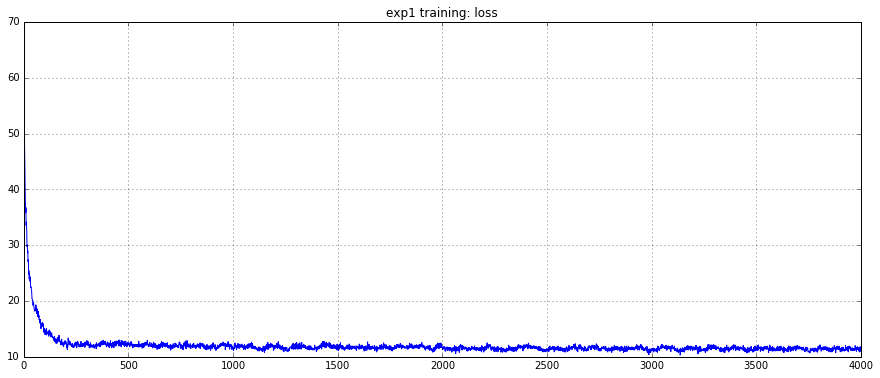

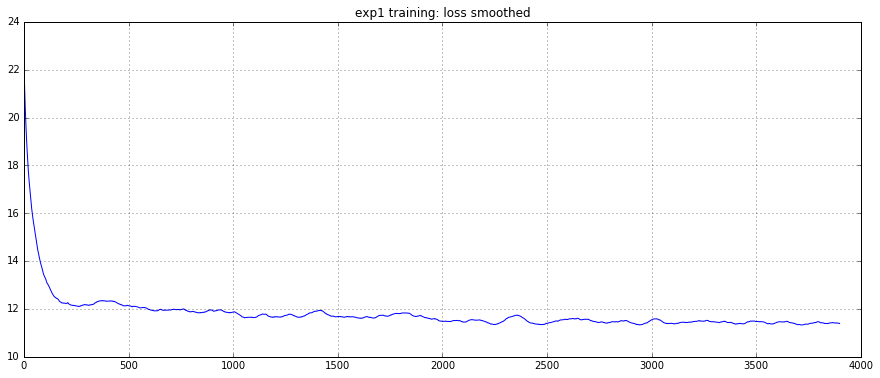

In [110]:
def get_losses(exp_id):
    """
    Gets all loss entries from the database and concatenates them into a vector
    """
    q_train = {'exp_id' : exp_id, 'train_results' : {'$exists' : True}}
    return np.array([_r['loss'] 
                     for r in coll.find(q_train, projection = ['train_results']) 
                     for _r in r['train_results']])

def plot_train_loss(exp_id, start_step=None, end_step=None, N_smooth = 100, plt_title = None):
    """
    Plots the training loss
    
    You will need to EDIT this part.
    """
    # get the losses from the database
    loss = get_losses(exp_id)

    if start_step is None:
        start_step = 0
    if end_step is None:
        end_step = len(loss)
    if plt_title is None:
        plt_title = exp_id
    
    # Only plot selected loss window
    loss = loss[start_step:end_step]
    
    # plot loss
    fig = plt.figure(figsize = (15, 6))
    plt.plot(loss)
    plt.title(plt_title + ' training: loss')
    plt.grid()
    axes = plt.gca()

    # plot smoothed loss
    smoothed_loss = signal.convolve(loss, np.ones((N_smooth,)))[N_smooth : -N_smooth] / float(N_smooth)
    plt.figure(figsize = (15, 6))
    plt.plot(smoothed_loss)
    plt.title(plt_title + ' training: loss smoothed')
    plt.grid()
    axes = plt.gca()

plot_train_loss('exp1')

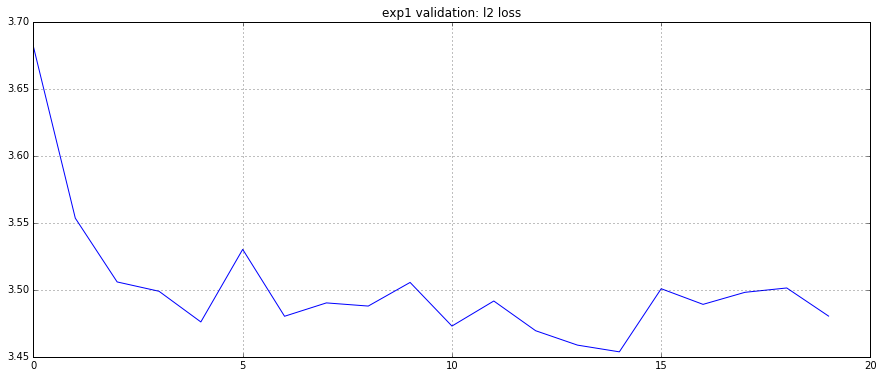

In [111]:
def get_validation_data(exp_id):
    """
    Gets the validation data from the database (except for gridfs data)
    """
    q_val = {'exp_id' : exp_id, 'validation_results' : {'$exists' : True}, 'validates' : {'$exists' : False}}
    val_steps = coll.find(q_val, projection = ['validation_results'])
    return [val_steps[i]['validation_results']['valid0']['total_loss'] 
            for i in range(val_steps.count())]

def plot_validation_results(exp_id, plt_title = None):
    """
    Plots the validation results i.e. the top1 and top5 accuracy
    
    You will need to EDIT this part.
    """
    # get the data from the database
    total_loss = get_validation_data(exp_id)
    
    if plt_title is None:
        plt_title = exp_id
    
    # plot top1 accuracy
    fig = plt.figure(figsize = (15, 6))
    plt.plot(total_loss)
    plt.title(plt_title + ' validation: l2 loss')
    plt.grid()
    axes = plt.gca()

plot_validation_results('exp1')

### Finally let's plot some example outputs of our autoencoder. The images to the left are the outputs. The images to the right are the inputs.

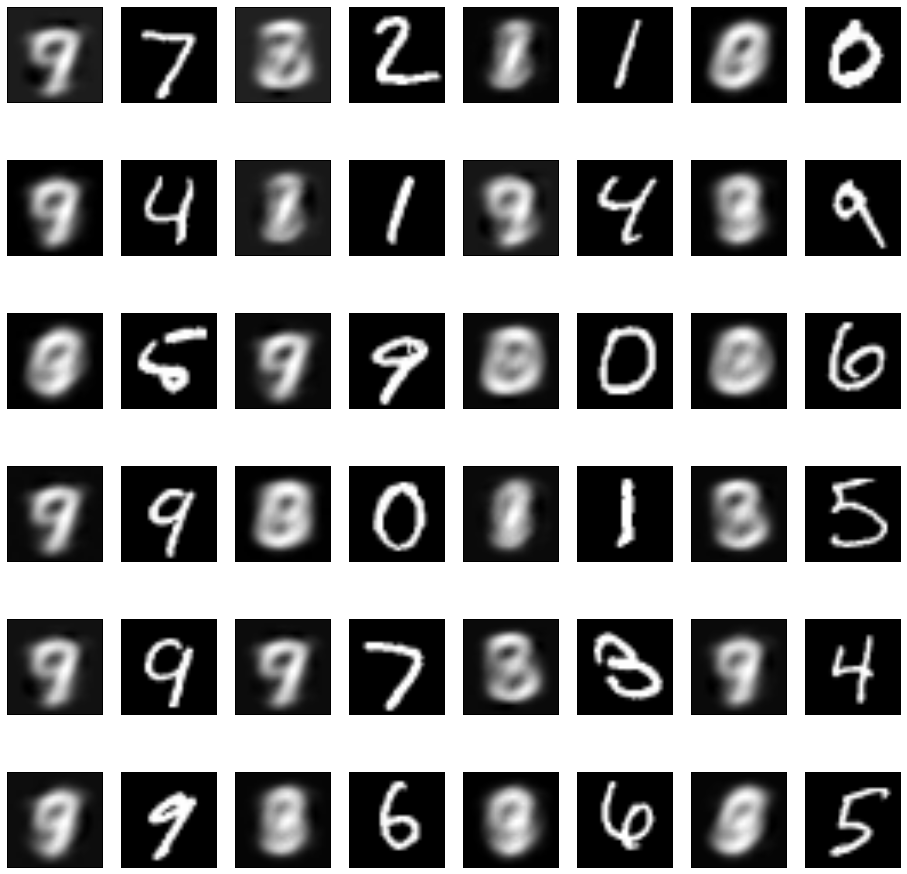

In [112]:
def get_validation_images(exp_id):
    """
    Gets the validation images from the database
    """
    q_val = {'exp_id' : exp_id, 'validation_results' : {'$exists' : True}, 'validates' : {'$exists' : False}}
    val_steps = coll.find(q_val, projection = ['validation_results'])
    pred = np.array([val_steps[i]['validation_results']['valid0']['pred'] 
            for i in range(val_steps.count())])
    gt = np.array([val_steps[i]['validation_results']['valid0']['gt'] 
            for i in range(val_steps.count())])
    return {'gt': gt, 'pred': pred}

def plot_validation_images(exp_id, n_images = 24):
    '''
    Plots n_images images in a grid. The ground truth image is on the left 
    and the prediction is on the right.
    '''
    imgs = get_validation_images(exp_id)
    fig = plt.figure(figsize=(16, 16))
    for i in range(n_images):
        pred = np.reshape(imgs['pred'][0,i], [28, 28])
        plt.subplot(n_images/4,n_images/3,1 + i*2)
        plt.imshow(pred, cmap='gray')
        ax = plt.gca()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        
        gt = np.reshape(imgs['gt'][0,i], [28, 28])
        plt.subplot(n_images/4,n_images/3,2 + i*2)
        plt.imshow(gt, cmap='gray')
        ax = plt.gca()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        
plot_validation_images('exp1')

## 2.) Training and evaluating a variational autoencoder on MNIST
### Similar to sparse autoencoders, variational autoencoders try to find a compact, representation of the input data, however this time modeling the input data distribution as a random normal distribution with a characteristic mean and standard deviation. The autoencoder structure remains fundamentally the same: We start with an encoder that encodes the input into a low dimensional latent space this time represented by its mean and standard deviation and a decoder that decodes the latent representation into the original input. Since we cannot backpropagate through a  randomly sampled gaussian distribution, we use the reparametrization trick to move the sampling into the input and make the model fully differentiable. Again, the supervision signal during training is the input itself and since we assume our data can be modeled by a normal distribution, we try to maximize the log likelihood while minimizing the KL divergence between the target distribution and our model in our loss.

### Now let's define a simple variational autoencoder as described above. We will first define the model function:

In [43]:
def variational_autoencoder(inputs, train=True, n_hidden = 100, n_latent = 20, **kwargs): 
    '''
    Implements a simple autoencoder consisting of two fully connected layers
    '''
    outputs = {}
    # flatten the input images
    inp = tf.reshape(inputs['images'], [inputs['images'].get_shape().as_list()[0], -1])
    
    # create encoder variables and encode the input
    with tf.variable_scope('encoder'):
        W_enc = tf.get_variable('W_enc', [784, n_hidden], tf.float32, tf.contrib.layers.xavier_initializer())
        b_enc = tf.get_variable('b_enc', [n_hidden], tf.float32, tf.constant_initializer(0))
        
        latent = tf.tanh(tf.matmul(inp, W_enc) + b_enc, name='hidden_encoding')
        
        W_mu = tf.get_variable('W_mu', [n_hidden, n_latent], tf.float32, tf.contrib.layers.xavier_initializer())
        b_mu = tf.get_variable('b_mu', [n_latent], tf.float32, tf.constant_initializer(0))
        mu = tf.matmul(latent, W_mu) + b_mu
        outputs['mu'] = mu
        
        W_logstd = tf.get_variable('W_logstd', [n_hidden, n_latent], tf.float32, tf.contrib.layers.xavier_initializer())
        b_logstd = tf.get_variable('b_logstd', [n_latent], tf.float32, tf.constant_initializer(0))
        logstd = tf.matmul(latent, W_logstd) + b_logstd
        outputs['logstd'] = logstd
        
        # reparameterization trick
        noise = tf.random_normal([1, n_latent])
        z = tf.add(mu, tf.multiply(noise, tf.exp(.5*logstd)), name='latent_encoding')
        
    # create decoder variables and decode the low dimensional representation
    with tf.variable_scope('decoder'):
        W_dec = tf.get_variable('W_dec', [n_latent, n_hidden], tf.float32, tf.contrib.layers.xavier_initializer())
        b_dec = tf.get_variable('b_dec', [n_hidden], tf.float32, tf.constant_initializer(0))
        hidden_output = tf.tanh(tf.matmul(z, W_dec) + b_dec, name='hidden_decoding')
        
        W_reconstruct = tf.get_variable('W_reconstruct', [n_hidden, 784], tf.float32, tf.contrib.layers.xavier_initializer())
        b_reconstruct = tf.get_variable('b_reconstruct', [784], tf.float32, tf.constant_initializer(0))
        outputs['pred'] = tf.sigmoid(tf.matmul(hidden_output, W_reconstruct) + b_reconstruct, name='decoding')
        
    return outputs, {}

### Now let's define the loss for our variational autoencoder:

In [59]:
def variational_autoencoder_loss(inputs, outputs, **kwargs):
    '''
    Defines the loss = l2(inputs - outputs) + l2(weights)
    '''
    # flatten the input images
    inputs = tf.reshape(inputs, [inputs.get_shape().as_list()[0], -1])
    # the total optimization target
    log_likelihood = tf.reduce_sum(inputs * tf.log(outputs['pred'] + 1e-9) + (1 - inputs) * tf.log(1 - outputs['pred'] + 1e-9), axis=1)
    KL_div = -0.5 * tf.reduce_sum(1 + 2 * outputs['logstd'] - tf.pow(outputs['mu'],2) - tf.exp(2 * outputs['logstd']), axis = 1)
    # Also ok: KL_div = 0.5 * tf.reduce_sum(tf.square(z_mu) + tf.square(z_stddev) - tf.log(tf.square(z_stddev)) - 1,1)
    variational_lower_bound = tf.reduce_mean(log_likelihood - KL_div)
    return -variational_lower_bound

def variational_autoencoder_validation(inputs, outputs, **kwargs):
    '''
    Wrapper for using the loss function as a validation target
    '''
    return {'total_loss': variational_autoencoder_loss(inputs['images'], outputs),
            'pred': outputs['pred'],
            'gt': inputs['images']}

### Now let's define our variational autoencoder experiment on MNIST in TFUtils. We will use the Adam optimizer and an exponentially decaying learning rate:

In [ ]:
os.environ['CUDA_VISIBLE_DEVICES'] = "2"

def online_agg_mean(agg_res, res, step):
    """
    Appends the mean value for each key
    """
    if agg_res is None:
        agg_res = {k: [] for k in res}
    for k, v in res.items():
        if k in ['pred', 'gt']:
            value = v
        else:
            value = np.mean(v)
        agg_res[k].append(value)
    return agg_res

def agg_mean(results):
    for k in results:
        if k in ['pred', 'gt']:
            results[k] = results[k][0]
        elif k is 'total_loss':
            results[k] = np.mean(results[k])
        else:
            raise KeyError('Unknown target')
    return results

# number of hidden neurons
n_hidden = 100
# dimension of latent space
n_latent = 20

params = {}

params['load_params'] = {
    'do_restore': False,
}

params['save_params'] = {
    'host': 'localhost',
    'port': 24444,
    'dbname': 'mnist',
    'collname': 'autoencoder',
    'exp_id': 'exp2',
    'save_metrics_freq': 200,
    'save_valid_freq': 200,
    'save_filters_freq': 1000,
    'cache_filters_freq': 1000,
}

params['train_params'] = {
    'validate_first': False,
    'data_params': {'func': data.MNIST,
                    'batch_size': 256,
                    'group': 'train',
                    'n_threads': 1},
    'queue_params': {'queue_type': 'random',
                     'batch_size': 256},
    'num_steps': 10000,
    'thres_loss': float("inf"),
}

params['validation_params'] = {'valid0': {
    'data_params': {'func': data.MNIST,
                    'batch_size': 100,
                    'group': 'test',
                    'n_threads': 1},
    'queue_params': {'queue_type': 'fifo',
                     'batch_size': 100},
    'num_steps': 100,
    'targets': {'func': variational_autoencoder_validation},
    'online_agg_func': online_agg_mean,
    'agg_func': agg_mean,
}}

params['model_params'] = {
    'func': variational_autoencoder,
    'n_latent': n_latent,
    'n_hidden': n_hidden,
} 

params['learning_rate_params'] = {
    'learning_rate': 5e-3,
    'decay_steps': 10000,
    'decay_rate': 0.95,
    'staircase': True,
}

params['optimizer_params'] = {
    'func': optimizer.ClipOptimizer,
    'optimizer_class': tf.train.AdamOptimizer,
    'clip': True,
}

params['loss_params'] = {
    'targets': ['images'],
    'loss_per_case_func': variational_autoencoder_loss,
    'loss_per_case_func_params' : {'_outputs': 'outputs', '_targets_$all': 'inputs'},
    'agg_func': tf.reduce_mean,
}

params['skip_check'] = True

coll.remove({'exp_id' : 'exp2'}, {'justOne': True})
base.train_from_params(**params)

### Now let's have a look at our training and validation curves that were stored in our database:

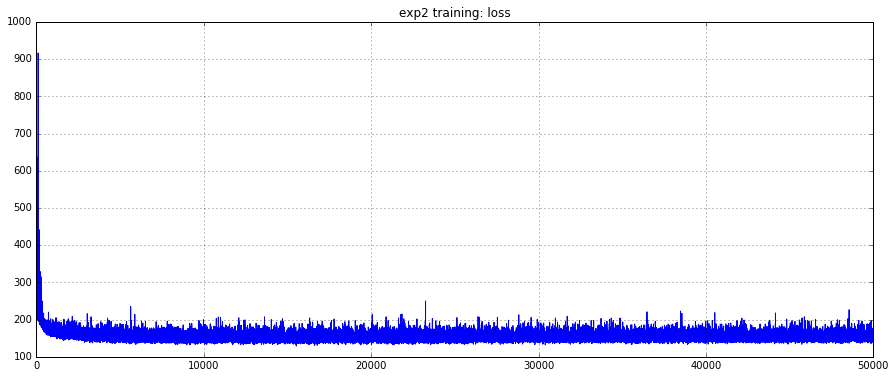

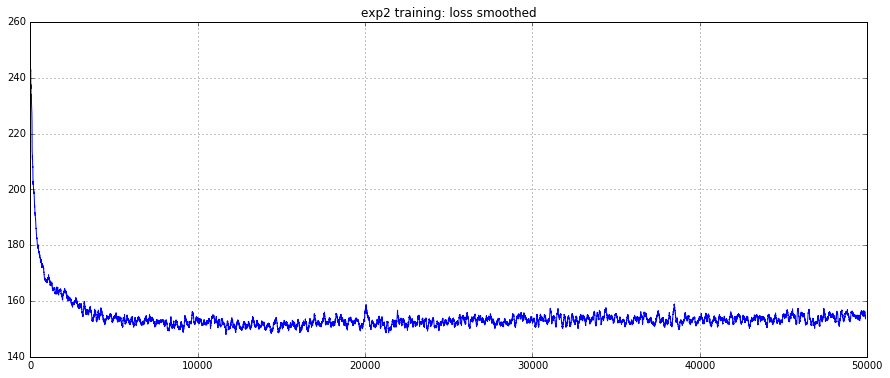

In [63]:
def get_losses(exp_id):
    """
    Gets all loss entries from the database and concatenates them into a vector
    """
    q_train = {'exp_id' : exp_id, 'train_results' : {'$exists' : True}}
    return np.array([_r['loss'] 
                     for r in coll.find(q_train, projection = ['train_results']) 
                     for _r in r['train_results']])

def plot_train_loss(exp_id, start_step=None, end_step=None, N_smooth = 100, plt_title = None):
    """
    Plots the training loss
    
    You will need to EDIT this part.
    """
    # get the losses from the database
    loss = get_losses(exp_id)

    if start_step is None:
        start_step = 0
    if end_step is None:
        end_step = len(loss)
    if plt_title is None:
        plt_title = exp_id
    
    # Only plot selected loss window
    loss = loss[start_step:end_step]
    
    # plot loss
    fig = plt.figure(figsize = (15, 6))
    plt.plot(loss)
    plt.title(plt_title + ' training: loss')
    plt.grid()
    axes = plt.gca()

    # plot smoothed loss
    smoothed_loss = signal.convolve(loss, np.ones((N_smooth,)))[N_smooth : -N_smooth] / float(N_smooth)
    plt.figure(figsize = (15, 6))
    plt.plot(smoothed_loss)
    plt.title(plt_title + ' training: loss smoothed')
    plt.grid()
    axes = plt.gca()

plot_train_loss('exp2')

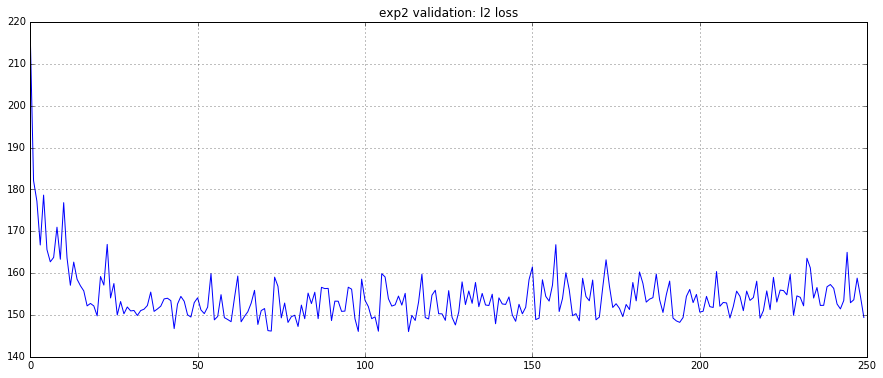

In [66]:
def get_validation_data(exp_id):
    """
    Gets the validation data from the database (except for gridfs data)
    """
    q_val = {'exp_id' : exp_id, 'validation_results' : {'$exists' : True}, 'validates' : {'$exists' : False}}
    val_steps = coll.find(q_val, projection = ['validation_results'])
    return [val_steps[i]['validation_results']['valid0']['total_loss'] 
            for i in range(val_steps.count())]

def plot_validation_results(exp_id, plt_title = None):
    """
    Plots the validation results i.e. the top1 and top5 accuracy
    
    You will need to EDIT this part.
    """
    # get the data from the database
    total_loss = get_validation_data(exp_id)
    
    if plt_title is None:
        plt_title = exp_id
    
    # plot top1 accuracy
    fig = plt.figure(figsize = (15, 6))
    plt.plot(total_loss)
    plt.title(plt_title + ' validation: l2 loss')
    plt.grid()
    axes = plt.gca()

plot_validation_results('exp2')

### Finally let's plot some example outputs of our autoencoder. The images to the left are the outputs. The images to the right are the inputs.

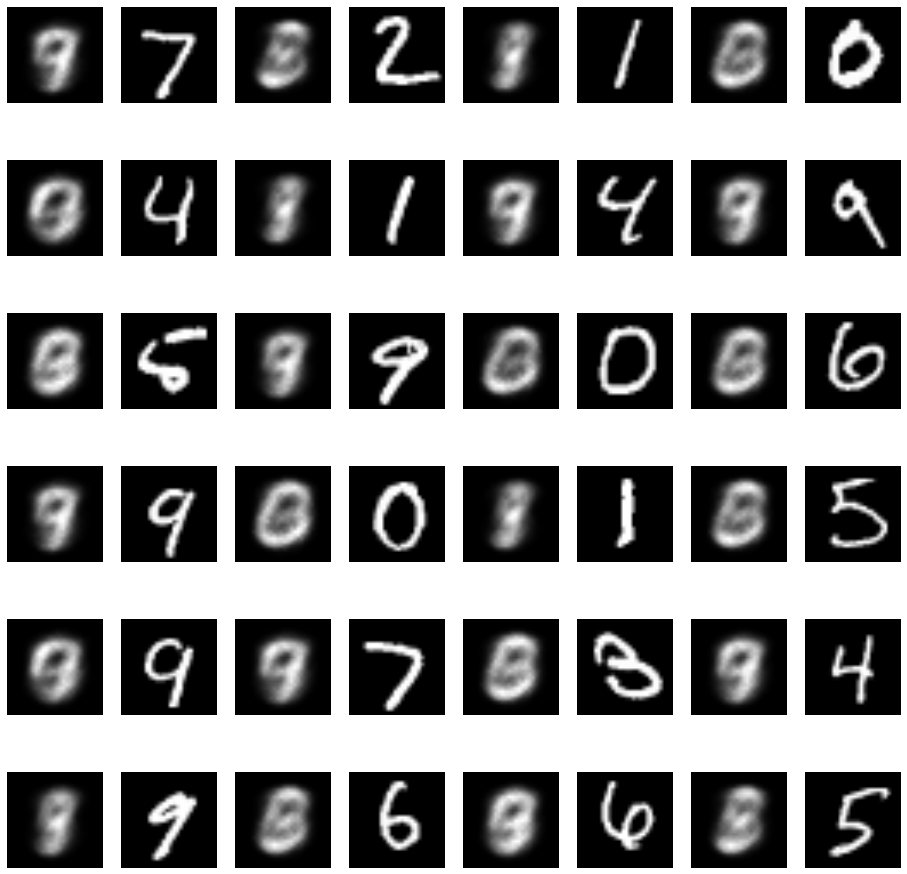

In [67]:
def get_validation_images(exp_id):
    """
    Gets the validation images from the database
    """
    q_val = {'exp_id' : exp_id, 'validation_results' : {'$exists' : True}, 'validates' : {'$exists' : False}}
    val_steps = coll.find(q_val, projection = ['validation_results'])
    pred = np.array([val_steps[i]['validation_results']['valid0']['pred'] 
            for i in range(val_steps.count())])
    gt = np.array([val_steps[i]['validation_results']['valid0']['gt'] 
            for i in range(val_steps.count())])
    return {'gt': gt, 'pred': pred}

def plot_validation_images(exp_id, n_images = 24):
    '''
    Plots n_images images in a grid. The ground truth image is on the left 
    and the prediction is on the right.
    '''
    imgs = get_validation_images(exp_id)
    fig = plt.figure(figsize=(16, 16))
    for i in range(n_images):
        pred = np.reshape(imgs['pred'][0,i], [28, 28])
        plt.subplot(n_images/4,n_images/3,1 + i*2)
        plt.imshow(pred, cmap='gray')
        ax = plt.gca()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        
        gt = np.reshape(imgs['gt'][0,i], [28, 28])
        plt.subplot(n_images/4,n_images/3,2 + i*2)
        plt.imshow(gt, cmap='gray')
        ax = plt.gca()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        
plot_validation_images('exp2')